<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch%20Applstra_%E4%BA%88%E6%B8%AC%E7%B5%90%E6%9E%9C%E3%82%921%E3%81%A4%E3%81%9A%E3%81%A4%E8%A1%A8%E7%A4%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#予測結果を1つずつ表示する

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#Google colabをマウント

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#モデルのロード

In [28]:
# モデルの設定
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device) #model_ftをGPUに載せる

# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/applstra/applstra.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
# image_pathの画像を表示する

def image_show(image_path):
    image=cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print("Not open:")
    #cv2_imshow(image)
    width2 = 500    #表示する横ピクセル数を記入
    height2 = int(width2 * image.shape[0]/image.shape[1])
    dst = cv2.resize(image, dsize=(width2, height2))

    cv2_imshow(dst)
    

def output(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = transform(image)
    #image = image.view(1,3,224,224)
    #print(image)
    #output = model_ft()
    #print(output)

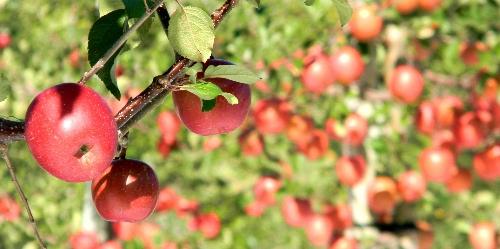

TypeError: ignored

In [60]:
image_path = '/content/drive/My Drive/Deep_learning/applstra/val/appl/P2019047.JPG'

image_show(image_path)
output(image_path)

#データセットを定義
（この中でvalセットを使用）

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Deep_learning/applstra'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '/val/'+class_names[k]))))
    k+=1

print("validating data set_total："+str(len(image_datasets)))

['appl', 'stra']
appl_val:67
stra_val:60
validating data set_total：2


In [0]:
print(image_datasets['val'][1])

(tensor([[[-1.5185, -1.5357, -1.5185,  ..., -1.5014, -1.5014, -1.5014],
         [-1.5185, -1.5185, -1.5185,  ..., -1.5185, -1.5014, -1.5014],
         [-1.5185, -1.5185, -1.5185,  ..., -1.5185, -1.5185, -1.5014],
         ...,
         [-2.0323, -2.0494, -2.0323,  ..., -2.1008, -2.0837, -2.1008],
         [-2.0323, -2.0323, -2.0494,  ..., -2.1008, -2.1008, -2.1008],
         [-2.0494, -2.0494, -2.0323,  ..., -2.1008, -2.1008, -2.1008]],

        [[-1.5280, -1.5455, -1.5280,  ..., -1.5105, -1.5105, -1.5105],
         [-1.5280, -1.5280, -1.5280,  ..., -1.5280, -1.5105, -1.5105],
         [-1.5280, -1.5280, -1.5280,  ..., -1.5280, -1.5280, -1.5105],
         ...,
         [-1.9482, -1.9657, -1.9482,  ..., -2.0182, -2.0007, -2.0182],
         [-1.9482, -1.9482, -1.9657,  ..., -2.0182, -2.0182, -2.0182],
         [-1.9657, -1.9657, -1.9482,  ..., -2.0182, -2.0182, -2.0182]],

        [[-1.2293, -1.2467, -1.2293,  ..., -1.2293, -1.2119, -1.2119],
         [-1.2293, -1.2293, -1.2293,  ..., -